# CD4+ T cell behavior in COVID-19 infection


In [1]:
# Load library and BoolNetPerturb functions
library(dplyr)
library(BoolNet)
library(alluvial)

source( 'BooleanHelper.r' )
for (f in list.files("BNP")) { source( paste('BNP/', f, sep='') ) }
# Load data
net <-  loadNetwork("data/thsocs_net.csv")
enviro <- read.csv("data/thsocs_environment.csv")
labels <- read.csv("data/thsocs_label.csv")

net.socs <- c('SOCS1', 'SOCS2', 'SOCS3', 'SOCS5')
net.ext  <- c('IFNGe', 'IL12e', 'IL2e', 'IL4e', 'IL6e', 'TGFBe', 'IL10e', 'TCR')

env.cov <- c('covmod', 'covsev', 'covtgfb', 'covil10')

net.cov <- list()
for (env in env.cov) {
    net.cov[env] <- list(fixGenes(net, colnames(enviro), enviro[env,]))
}


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



## CD4+ T cell regulatory network and subsets

### Regulatory network
* nodes: 22       
* edges: 82       


In [2]:
print(c('# nodes :', length(net$genes)))
net.topo <- getNetTopology(net)
writexl::write_xlsx(net.topo,'results/thsocs_net_topology.xlsx')
print(c('# edges :', length(net.topo[[1]]) - sum(sapply(net$genes, isGeneInput, net=net))  ))

[1] "# nodes :" "21"       
[1] "# edges :" "81"       


### Attractors

* Naive
* Th0
* Th1
* Th2
* Th17
* Treg
* Tr - including TrIL4+
* Th1R - including Treg IFNG+ & IL4+ \cite{}
* Th2R
* Anergy

[1] Th17  Treg  Tr    Tex   Th1R  Th2R  Th2   Th1   Naive
Levels: Naive Tex Th1 Th17 Th1R Th2 Th2R Tr Treg

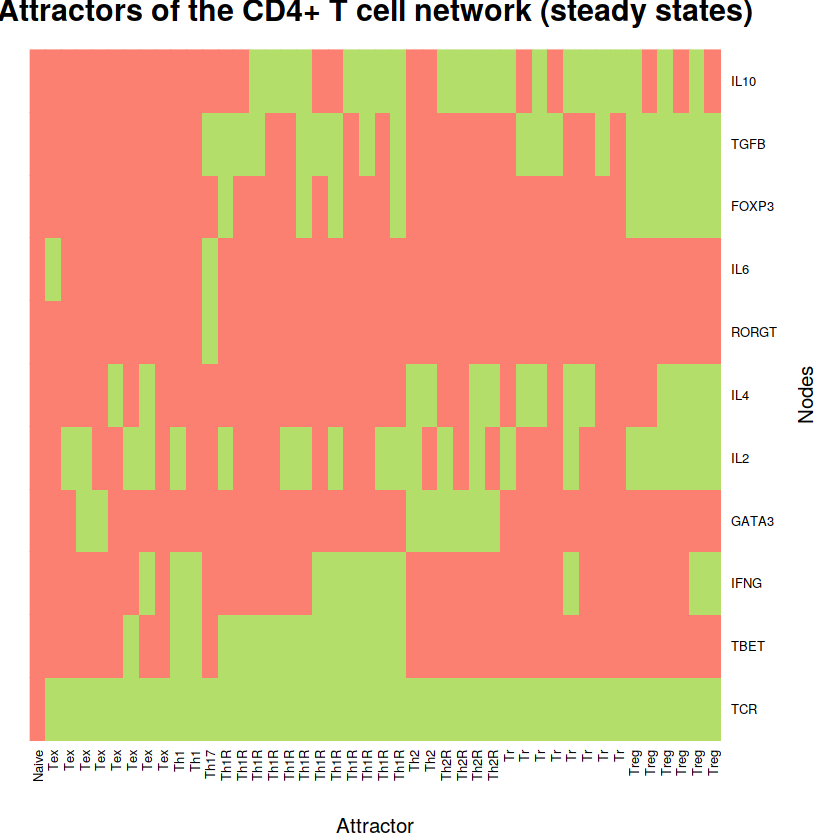

In [3]:
attr.table <- get.attr.table(net, labels, simplify=T, method="sat.exhaustive",
                             file.name='results/thsocs_attr_table.csv' )
#tail(attr.table,10)
unique(attr.table$label)

selected.nodes <- c("TCR", "TBET","IFNG","GATA3","IL2","IL4","RORGT","IL6","FOXP3","TGFB","IL10")
file.attr.fig <- "images/thsocs_attr_table.eps"
plot.attr.table(attr.table, file.name=NULL,
                title='Attractors of the CD4+ T cell network', selected.nodes=selected.nodes)

## Basin size by environment

* CoV-mod has the same signature as Th1
* CoV-mod and CoV-sev have similar presence of celltypes:
    * Anergy, Th1, Th1R, Th2R, Tr
* In CoV-sev increase in anergy and Th1r, decreese in Th1, really high increase in Th0
    * Are we seeing anergy or cells that do not differentiate ever by signalling pathway competition
* If there is TGFB in CoV-sev we have Th17, Th1R and Tr with no Treg or Th1
    * possible worst outcome, activation of innate inflamation, no adaptive citotoxicity, also fibrosis
    * check TGFB in patients, while it may have regulatory effects it may induce 
    * role of microenvironment in pathology

In [4]:
# plot environments
enviro

,IFNGe,IL12e,IL2e,IL4e,IL6e,TGFBe,IL10e
Basal,0,0,0,0,0,0,0
pro-Th1,1,1,0,0,0,0,0
pro-Th2,0,0,1,1,0,0,0
pro-Th17,0,0,0,0,1,1,0
pro-Treg,0,0,1,0,0,1,0
pro-Tr,0,0,0,0,0,1,1
covmod,1,1,0,0,0,0,0
covsev,1,1,0,1,1,0,0
covtgfb,1,1,0,1,1,1,0
covil10,1,1,0,1,1,0,1


In [5]:
file.env.attr <- "results/thsocs_env_attr.csv"
file.env.attr.fig <- "images/thsocs_env_attr.eps"


env.attr <- perturbNetworkFixedNodes(net, label.rules=labels, returnDataFrame='basinSize',
                                     genes  = rep( list(colnames(enviro)), times=nrow(enviro) ),
                                     values = lapply( split(enviro,seq_along(enviro[,1])), as.list),
                                     names  = rownames(enviro))
write.csv(env.attr,file.env.attr)
env.attr <- env.attr[row.names(env.attr) != "Naive", , drop = FALSE]
env.attr[] <- lapply( env.attr[], function(x) x/sum(x) )
env.attr  * 100

setEPS(); postscript(file.env.attr.fig)
env.attr[env.attr == 0] <- NA
colfunc <- colorRampPalette(c('#fee391', '#a65628'))
color <- colfunc(10)
heatmap(t(as.matrix( subset(env.attr ))),
        main="CD4+ T subsets by environment", 
        xlab="CD4+ T cell subset", ylab="Environment",
        col=color, cexCol=0.75, cexRow=0.75,
        Colv = NA, Rowv = NA, scale="none",
       )
dev.off()

,Basal,pro-Th1,pro-Th2,pro-Th17,pro-Treg,pro-Tr,covmod,covsev,covtgfb,covil10
Tex,50.9277344,7.5195312,4.8095703,0.000000,0.0000000,0.00000,7.5195312,32.1289062,0.00000,0.000000
Th1,5.7373047,38.3300781,1.6601562,0.000000,0.0000000,0.00000,38.3300781,24.0234375,0.00000,0.000000
Th17,0.0000000,0.0000000,0.0000000,53.125000,0.9521484,0.00000,0.0000000,0.0000000,21.09375,0.000000
Th1R,12.7441406,48.7792969,1.6113281,6.640625,16.3085938,16.30859,48.7792969,38.9648438,62.98828,63.867188
Th2,4.7607422,0.0000000,54.9560547,0.000000,0.0000000,0.00000,0.0000000,0.0000000,0.00000,0.000000
Th2R,0.6835938,0.5371094,0.6835938,0.000000,0.0000000,0.00000,0.5371094,0.4882812,0.00000,1.171875
Tr,25.1464844,4.8339844,7.2753906,40.234375,12.8784180,83.69141,4.8339844,4.3945312,15.91797,34.960938
Treg,0.0000000,0.0000000,29.0039062,0.000000,69.8608398,0.00000,0.0000000,0.0000000,0.00000,0.000000


png 
  2

## CD4+ T cell stability and plasticity in COVID-19

In [6]:
f.cfm.table <- function(net, labels, file.name, time=1, replace=list()) {
    cfm <- cellFateMap(net, label.rules=labels, time=time,
                       method="sat.restricted", maxAttractorLength=2) 
    cfm <- apply(cfm,2,as.character)
    cfm <- cfm[  order( cfm[,1], cfm[,2], cfm[,3], cfm[,4] ),]
    write.csv(cfm,file.name, row.names=F)
    cfm <- read.csv(file.name, stringsAsFactors=F)
    for (old in names(replace)) {
        new <- replace[old]
        cfm[cfm[,2]==old,2] <- new
    }
    write.csv(cfm,file.name, row.names=F)
    cfm <- read.csv(file.name, stringsAsFactors=F)
    cfm
}

In [7]:
cfm.cov <- list()
for (env in env.cov) {
    file.name <- paste(c("results/thsocs_cfm_",env,".csv"), collapse='')
    print(file.name)
    cfm <- f.cfm.table(net.cov[[env]], labels, file.name)
    cfm.cov[env] <- list(cfm)
}

[1] "results/thsocs_cfm_covmod.csv"
[1] "results/thsocs_cfm_covsev.csv"
[1] "results/thsocs_cfm_covtgfb.csv"
[1] "results/thsocs_cfm_covil10.csv"


In [8]:
replace <- list('TexTex'='Tex',"Th1RTex"="Tr*","Th1RTh17RTex"="Tr*","Th2RTh17RTex"="Tr*","Th17RTex"="Tr*","Naive"="Tex")
mut.cov <- list()
for (env in env.cov) {
    file.name <- paste(c("results/thsocs_mut_",env,".csv"), collapse='')
    print(file.name)
    mut <- f.cfm.table(net.cov[[env]], labels, file.name, time=NULL, replace=replace)
    mut.cov[env] <- list(mut)
}

[1] "results/thsocs_mut_covmod.csv"
[1] "results/thsocs_mut_covsev.csv"
[1] "results/thsocs_mut_covtgfb.csv"
[1] "results/thsocs_mut_covil10.csv"


### Stability by celltype

* CoV-mod, Th1 > Anergy both in basin size, stablity, and transitions towards
* CoV-sev, Th1 < Anergy both in basin size, stablity, and transitions towards
* Cov-TGFB, no anergy nor Th1, presence of Th17 and transitions towards
* Discuss roles of local microenvironment

In [9]:
plot.cfm.alluvial <- function(cfm, file.name=NULL, title='', ignore='Naive') {
    if (!is.null(file.name)) {
        setEPS(); cairo_ps(file.name)
        }
    cfm <- cfm[cfm$initial!=ignore,]
    cfm2d <- cfm %>% group_by(initial, final) %>%
            summarize(freq = n())
    print(title)
    alluvial(cfm2d[,1:2], freq=cfm2d$freq)
    if (!is.null(file.name)) { dev.off() }
    }

In [10]:
for (env in env.cov) {
    print(env)
    #file.name <- NULL
    file.name <- paste(c("images/thsocs_cfm_alluvial_",env,".eps"), collapse='')
    title <- paste(c("Transitions between cell types in ",env, "\n with perturbations of time 1"), collapse='')
    plot.cfm.alluvial(cfm.cov[[env]], file.name, title)
}

[1] "covmod"
[1] "Transitions between cell types in covmod\n with perturbations of time 1"
[1] "covsev"
[1] "Transitions between cell types in covsev\n with perturbations of time 1"
[1] "covtgfb"
[1] "Transitions between cell types in covtgfb\n with perturbations of time 1"
[1] "covil10"
[1] "Transitions between cell types in covil10\n with perturbations of time 1"


In [11]:
for (env in env.cov) {
    print(env)
    #file.name <- NULL
    file.name <- paste(c("images/thsocs_mut_alluvial_",env,".eps"), collapse='')
    title <- paste(c("Transitions between cell types in ",env, "\n with perturbations of time infty"), collapse='')
    plot.cfm.alluvial(mut.cov[[env]], file.name, title)
}

[1] "covmod"
[1] "Transitions between cell types in covmod\n with perturbations of time infty"
[1] "covsev"
[1] "Transitions between cell types in covsev\n with perturbations of time infty"
[1] "covtgfb"
[1] "Transitions between cell types in covtgfb\n with perturbations of time infty"
[1] "covil10"
[1] "Transitions between cell types in covil10\n with perturbations of time infty"


### Transitions by node

Key nodes: IFNG, IL10, TGFB (and TCR)

In [12]:
plot.node.transitions <- function(cfm, file.name=NULL, title='', normalize=T) {
    cfm.diff <- cfm[cfm$initial!=cfm$final,]
    node.transitions <- merge( summary(as.factor(cfm.diff[cfm.diff$values==0,'genes'])), 
                               summary(as.factor(cfm.diff[cfm.diff$values==1,'genes'])),
                               by=0, all=TRUE)
    rownames(node.transitions) <- node.transitions$Row.names
    node.transitions <- subset(node.transitions, select = -Row.names )
    colnames(node.transitions) <- c('activation','inhibition')
    # format to standarize node names
    node.transitions <- merge( net$genes, node.transitions,
                               by.x=1, by.y=0, all=TRUE)
    node.transitions[is.na(node.transitions)] <- 0
    rownames(node.transitions) <- node.transitions$x
    node.transitions <- subset(node.transitions, select = -x )
    node.transitions <- node.transitions[net$genes,]
    if (normalize) { node.transitions <- node.transitions/summary(as.factor(cfm$genes)) }
    #print(node.transitions)
    # plot plot
    if (!is.null(file.name)) {
        setEPS(); postscript(file.name)
    }
    barplot(t(as.matrix( node.transitions )),
            main=title, xlab='nodes', ylab='% of transitions caused when perturbed',
            col=c('#b3de69','#fb8072'), ylim=c(0,1), las=2, legend=T,
           )
    if (!is.null(file.name)) { dev.off() }
}


In [13]:
for (env in env.cov) {
    print(env)
    file.name <- NULL
    file.name <- paste(c("images/thsocs_cfm_trannode_",env,".eps"), collapse='')
    title <- paste(c("Transitions among subsets by node in ",env, "\n with perturbations of time 1"), collapse='')
    plot.node.transitions(cfm.cov[[env]], file.name, title)
}

[1] "covmod"
[1] "covsev"
[1] "covtgfb"
[1] "covil10"


In [14]:
for (env in env.cov) {
    print(env)
    file.name <- NULL
    file.name <- paste(c("images/thsocs_mut_trannode_",env,".eps"), collapse='')
    title <- paste(c("Transitions among subsets by node in ",env, "\n with perturbations of time infty"), collapse='')
    plot.node.transitions(mut.cov[[env]], file.name, title)
}

[1] "covmod"
[1] "covsev"
[1] "covtgfb"
[1] "covil10"


## CD4+ T cell KO and overexpression mutants in COVID-19
    * [/] Mutants in WT, covmod, and covsev table
    * [/] Mutants in WT, covmod, and covsev scale:purple
    * [/] Compare covmod vs covsev

In [16]:
f.mut.table <- function(net, lab, file.name) {
    mutants <- perturbNetworkFixedNodes(net, label.rules=lab, returnDataFrame='basinSize')
    mut_socs <- perturbNetworkFixedNodes(net, label.rules=lab, returnDataFrame='basinSize',
                                         genes  = list(c('SOCS1','SOCS2','SOCS3'),c('SOCS1','SOCS2','SOCS3')),
                                         values = list(0,1),
                                         names  = c('SOCSall_0','SOCSall_1'))
    mutants <- merge(mutants, mut_socs, by=0, all=TRUE)
    rownames(mutants) <- mutants$Row.names
    mutants <- mutants[ , -which(names(mutants) %in% c("Row.names"))]
    mutants[mutants == 0] <- NA
    write.csv(mutants,file.name)
    mutants
}

f.mut.plot <- function(mutants, file.name=NULL, title='', normalize=T) {
    if (normalize) {
        mutants <- mutants/mutants
        color <- c('#bebada')
    } else {
        colfunc <- colorRampPalette(c('#bfd3e6', '#810f7c'))
        color <- colfunc(10)
    }
    if (!is.null(file.name)) {
        setEPS(); postscript(file.name)
    }
    mutants
    heatmap(t(as.matrix( mutants )),
            main=title, 
            xlab="Attractor", ylab="Mutant",
            col=color, cexCol=0.75, cexRow=0.75,
            Colv = NA, Rowv = NA, scale="none",
           )
    if (!is.null(file.name)) { dev.off() }

}

In [18]:
for (env in env.cov) {
    print(env)
    file.name <- paste(c("results/thsocs_mut_",env,".csv"), collapse='')
    mut <- f.mut.table(net.cov[[env]], labels, file.name)
    
    file.name <- NULL
    file.name <- paste(c("images/thsocs_mut_",env,".eps"), collapse='')    
    title <- paste(c("Transitions among subsets by node in ",env, "\n with perturbations of time infty"), collapse='')
    f.mut.plot(mut, file.name, title, normalize=F)
}

[1] "covmod"
[1] "covsev"
[1] "covtgfb"
[1] "covil10"


Done